# Figure 4

## a

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from flyvision import EnsembleView
from flyvision.analysis.visualization import plots
from flyvision.analysis.moving_bar_responses import plot_angular_tuning

In [2]:
ensemble = EnsembleView("flow/0000")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-10-04 22:44:38] ensemble:142 Loaded 50 networks.


In [3]:
stims_and_resps = ensemble.moving_edge_responses()

In [4]:
stims_and_resps['responses'] /= (norm := ensemble.responses_norm(rectified=True))

In [5]:
# retrieve cluster indices for averaging across best clusters
cell_types = [
    "L1",
    "L2",
    "L3",
    "L4",
    "L5",
    "Mi1",
    "Tm3",
    "Mi4",
    "Mi9",
    "CT1(M10)",
    "T4a",
    "T4b",
    "T4c",
    "T4d",
    "T5a",
    "T5b",
    "T5c",
    "T5d",
    "Tm1",
    "Tm2",
    "Tm4",
    "Tm9",
    "CT1(Lo1)",
    "TmY3",
]
cluster_indices = {}
for cell_type in cell_types:
    if cell_type not in cluster_indices:
        cluster_indices[cell_type] = ensemble.cluster_indices(cell_type)

[2024-10-04 22:45:01] clustering:643 Loaded L1 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.


[2024-10-04 22:45:03] clustering:643 Loaded L2 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-10-04 22:45:03] clustering:643 Loaded L3 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-10-04 22:45:03] clustering:643 Loaded L4 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-10-04 22:45:04] clustering:643 Loaded L5 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-10-04 22:45:04] clustering:643 Loaded Mi1 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-10-04 22:45:05] clustering:643 Loaded Tm3 embedding and clustering from /groups/turaga/home/lappal

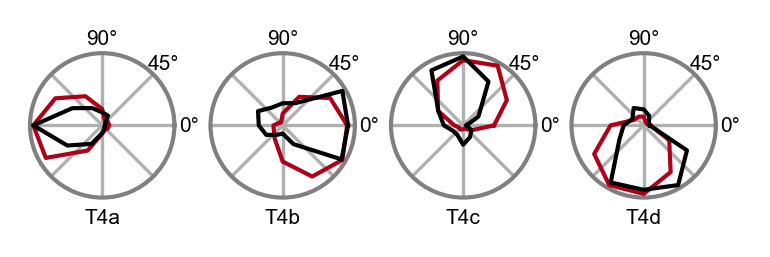

In [6]:
# plot the tuning across the best clusters
fig, axes, _ = plots.plt_utils.get_axis_grid(
    range(4),
    projection="polar",
    aspect_ratio=4,
    figsize=[2.95, 0.83],
    wspace=0.25,
)
for i, cell_type in enumerate(["T4a", "T4b", "T4c", "T4d"]):
    plot_angular_tuning(
        stims_and_resps.sel(network_id=cluster_indices[cell_type][0]),
        cell_type=cell_type,
        intensity=1,
        fig=fig,
        ax=axes[i],
        groundtruth=True,
        groundtruth_linewidth=1.0,
        average_models=True,
        model_dim=2,
        zorder=100,
    )
    axes[i].set_xlabel(cell_type)

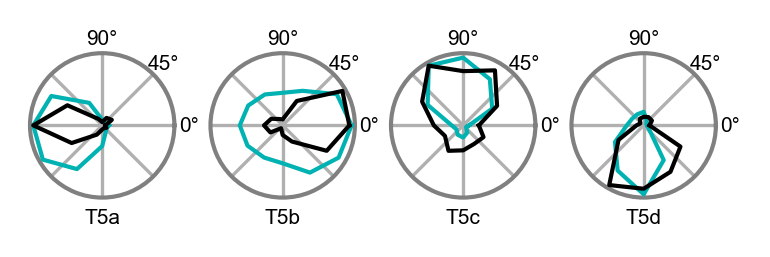

In [7]:
fig, axes, _ = plots.plt_utils.get_axis_grid(
    range(4),
    projection="polar",
    aspect_ratio=4,
    figsize=[2.95, 0.83],
    wspace=0.25,
)
for i, cell_type in enumerate(["T5a", "T5b", "T5c", "T5d"]):
    plot_angular_tuning(
        stims_and_resps.sel(network_id=cluster_indices[cell_type][0]),
        cell_type=cell_type,
        intensity=0,
        fig=fig,
        ax=axes[i],
        groundtruth=True,
        groundtruth_linewidth=1.0,
        average_models=True,
        model_dim=2,
        zorder=100,
    )
    axes[i].set_xlabel(cell_type)

## b

In [8]:
from datamate import namespacify

from flyvision.analysis.moving_edge_currents import CellTypeArray, MovingEdgeCurrentView
from flyvision.datasets import MovingEdge

In [9]:
target_types = ["T4c"]

In [10]:
experiment_data = ensemble.moving_edge_currents()

In [11]:
dataset = MovingEdge(**experiment_data[0].config)

In [12]:
current_views = {}

In [13]:
norm = CellTypeArray(ensemble.responses_norm(rectified=False), ensemble[0].connectome)

In [14]:
for target_type in target_types:
    if target_type not in current_views:
        current_views[target_type] = MovingEdgeCurrentView(
            ensemble, target_type, experiment_data, dataset.arg_df
        )
    view = current_views[target_type]

In [15]:
for target_type in target_types:
    current_views[target_type] = view.divide_by_given_norm(norm)

In [16]:
cell_type = "T4c"
current_view = current_views[cell_type]

Text(0.5, 0, 'time (s)')

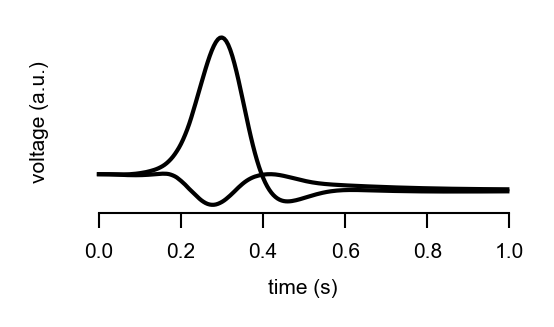

In [17]:
fig, ax = current_view.model_selection(cluster_indices[cell_type][0]).plot_response(
    1, 90, t_end=1.0
)
xlim_responses = ax.get_xlim()
ax.set_ylabel("voltage (a.u.)", fontsize=5)
ax.set_xlabel("time (s)", fontsize=5)

Text(0, 0.5, 'current (a.u.)')

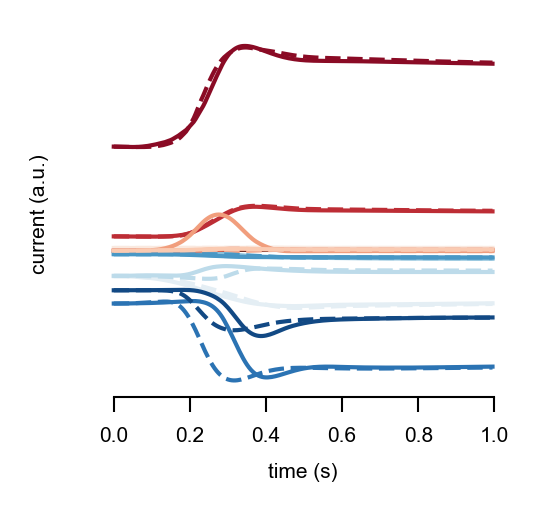

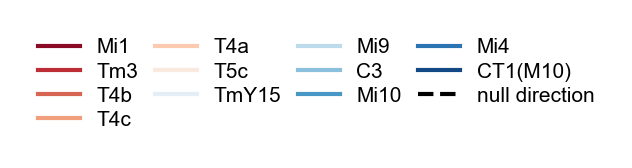

In [18]:
fig, ax, legend_fig, legend_ax = current_view.model_selection(
    cluster_indices[cell_type][0]
).plot_temporal_contributions(
    1,
    90,
    t_start=0,
    t_end=1,
    model_average=True,
    legend=False,
    sum_exc_inh=False,
    only_sum=False,
    max_figure_height_cm=3.3941,
    panel_height_cm=3.3941,
    max_figure_width_cm=4.0513,
    panel_width_cm=4.0513,
    hide_source_types=None,
)
ylim = ax.get_ylim()
ax.set_ylabel("current (a.u.)", fontsize=5)

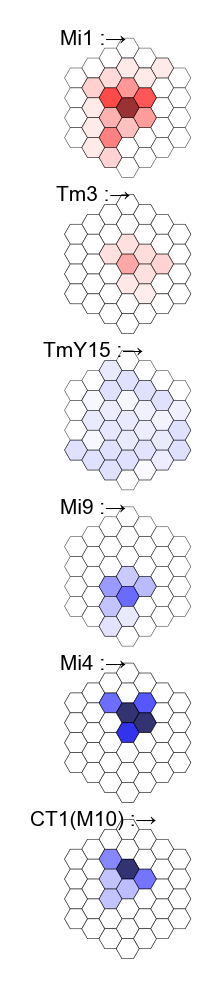

In [19]:
fig, ax, _ = current_view.model_selection(
    cluster_indices[cell_type][0]
).plot_spatial_contribution_grid(
    t_start=0,
    t_end=1,
)

## d

In [20]:
from flyvision.utils.color_utils import flash_response_color_labels
from flyvision.analysis.visualization.figsize_utils import fit_panel_size
from scipy.signal import find_peaks
from flyvision.utils.hex_utils import hex_rows
from flyvision.analysis.visualization import plt_utils, plots
from flyvision.analysis.visualization.plots import plot_strf
from flyvision.datasets.dots import SpatialImpulses

In [21]:
norm = ensemble.responses_norm()

In [22]:
flashes_and_resps = ensemble.spatial_impulses_responses()
flashes_and_resps['responses'] = flashes_and_resps['responses'] / norm

In [23]:
dataset = SpatialImpulses(**flashes_and_resps.attrs['config'])

In [24]:
srf_cell_types = [
    "Mi1",
    "Tm3",
    "Mi4",
    "Mi9",
    "CT1(M10)",
    "Tm1",
    "Tm2",
    "Tm4",
    "Tm9",
    "CT1(Lo1)",
]

In [25]:
def strf_to_srf(strf):
    # subtract spatial mean of baseline response
    strf = (strf - strf.isel(frame=0).mean("sample").item()).squeeze().values.T

    # find the absmax of the response to central impulse, corresponding to
    # x.shape[0]//2
    absmax_index = find_peaks(np.abs(strf[:, strf.shape[1] // 2]))[0]
    absmax_index = absmax_index[0] if absmax_index.any() else 0
    return strf[absmax_index].squeeze()


mean_srfs = {}
for cell_type in srf_cell_types:
    strfs = (
        flashes_and_resps['responses']
        .sel(network_id=cluster_indices[cell_type][0])
        .custom.where(time=">=0,<0.25", t_impulse=0.02, cell_type=cell_type, intensity=1)
        .mean("network_id")
    )
    mean_srfs[cell_type] = strf_to_srf(strfs)

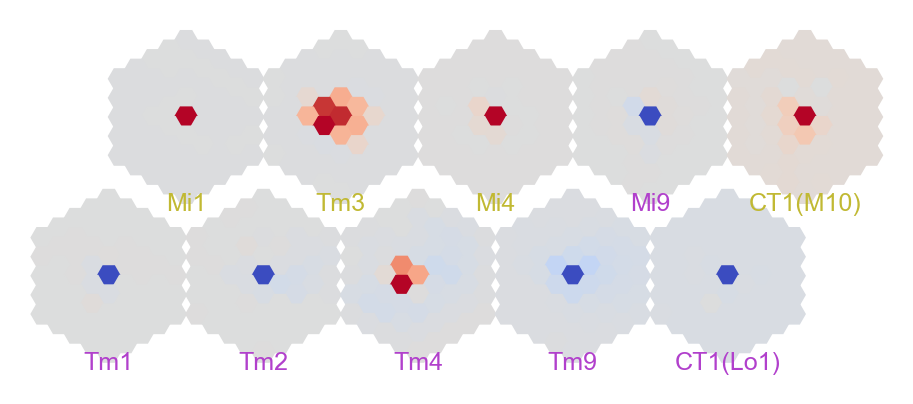

In [26]:
x, y = hex_rows(2, 5)
fig, axes, pos = plt_utils.ax_scatter(
    x, y, figsize=[3.5, 2], hpad=0, wpad=0.1, wspace=-0.5, hspace=-0.4
)

axes = np.array(axes).reshape(2, 5)

for i, row in enumerate(np.array(srf_cell_types).reshape(2, 5)):
    for j, cell_type in enumerate(row):
        crange = np.max(np.abs(mean_srfs[cell_type]))
        fig, ax, _ = plots.hex_scatter(
            dataset.dots.u,
            dataset.dots.v,
            mean_srfs[cell_type],
            cmap=plt.cm.coolwarm,
            vmin=-crange,
            vmax=crange,
            figsize=[3, 3],
            cbar=False,
            fig=fig,
            ax=axes[1 - i, j],
        )
        ax.set_xlabel(cell_type, fontsize=6, labelpad=-10)

for ax in axes.flatten():
    flash_response_color_labels(ax)

## e

In [27]:
from flyvision.datasets.dots import CentralImpulses

In [28]:
central_flash_and_resps = ensemble.central_impulses_responses()
central_flash_and_resps['responses'] = central_flash_and_resps['responses'] / norm

In [29]:
dataset = CentralImpulses(**central_flash_and_resps.attrs['config'])

In [30]:
trf_cell_types = np.array([
    "Mi1",
    "Tm3",
    "Mi4",
    "Mi9",
    "CT1(M10)",
    "Tm1",
    "Tm2",
    "Tm4",
    "Tm9",
    "CT1(Lo1)",
    "L1",
    "L2",
    "L3",
    "L4",
    "L5",
]).reshape(5, 3, order="F")

In [31]:
durations = [0.02, 0.05, 0.1, 0.2, 0.3]
on_cmap = plt_utils.truncate_colormap(plt.cm.Blues_r, minval=0.0, maxval=0.4).resampled(
    len(durations)
)
off_cmap = plt_utils.truncate_colormap(plt.cm.Blues_r, minval=0.5, maxval=0.9).resampled(
    len(durations)
)
cmaps = {
    1.0: [on_cmap(i) for i in range(on_cmap.N)][::-1],
    0: [off_cmap(i) for i in range(off_cmap.N)][::-1],
}

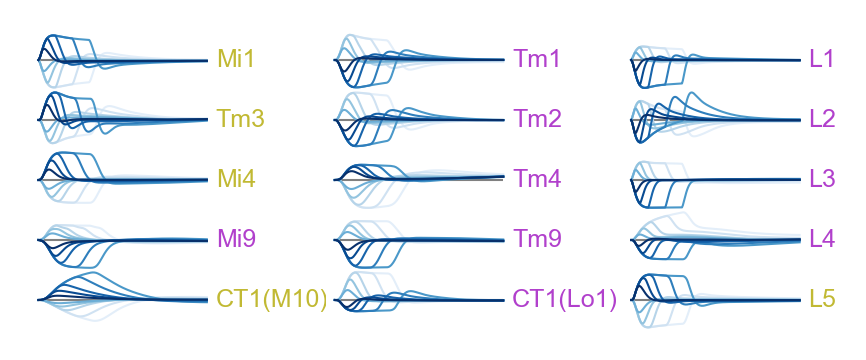

In [32]:
fig, axes = fit_panel_size(
    5,
    3,
    max_figure_height_cm=5.35,
    max_figure_width_cm=8,
    panel_width_cm=8 / 3,
    panel_height_cm=5.35 / 10,
).axis_grid(wspace=0.6, hspace=0.0, as_matrix=True)
for i, row in enumerate(trf_cell_types):
    for j, cell_type in enumerate(row):
        ax = axes[i, j]
        for q, duration in enumerate(durations[::-1]):
            for intensity in [0, 1]:
                color = cmaps[intensity][
                    q
                ]  # plt.cm.Blues(256) if intensity == 1 else plt.cm.Blues(128)
                #                 linestyle = "solid" if intensity == 1 else "dashed"
                zorder = 1 if intensity == 1 else 0

                r = (
                    central_flash_and_resps['responses']
                    .sel(network_id=cluster_indices[cell_type][0])
                    .custom.where(
                        time=">=0,<1.0",
                        cell_type=cell_type,
                        intensity=intensity,
                        t_impulse=duration,
                    )
                    .mean("network_id")
                )
                # subtract baseline after model averaging to plot it centered
                mean = (r - r.isel(frame=0).values).squeeze()
                ax.plot(r.time, mean, linewidth=0.5, color=color, zorder=zorder)
        ax.hlines(
            mean[0],
            r.time.min(),
            r.time.max(),
            linewidth=0.5,
            color="0.5",
            zorder=-1,
        )

        plt_utils.rm_spines(ax)
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(
            cell_type,
            fontsize=6,
            rotation=0,
            ha="left",
            va="center",
            labelpad=0.1,
        )
        #         ylim = np.array)
        ylim = np.array(ax.get_ylim())
        ylim = (-max(abs(ylim)), max(abs(ylim)))
        ax.set_ylim(ylim)

for ax in axes.flatten():
    flash_response_color_labels(ax)

stimulus

(-1.05, 1.05)

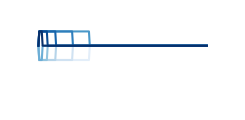

In [33]:
fig, axes = fit_panel_size(
    5,
    3,
    max_figure_height_cm=5.35,
    max_figure_width_cm=8,
    panel_width_cm=8 / 3,
    panel_height_cm=5.35 / 10,
).axis_grid(wspace=0.6, hspace=0.0, as_matrix=True, unmask_n=1)
ax = axes[0, 0]
for j, duration in enumerate(durations[::-1]):
    for intensity in [0, 1]:
        color = cmaps[intensity][j]
        #                 linestyle = "solid" if intensity == 1 else "dashed"
        zorder = 1 if intensity == 1 else 0
        stim = (
            central_flash_and_resps['stimulus']
            .custom.where(
                time=f">=-{2 * central_flash_and_resps.attrs['config']['dt']},<1.0",
                intensity=intensity,
                t_impulse=duration,
                u_in=0,
                v_in=0,
            )
            .squeeze()
        )
        ax.plot(stim, linewidth=0.5, color=color, zorder=zorder)
ax.hlines(
    0,
    stim.time.min(),
    stim.time.max(),
    linewidth=0.5,
    color="0.5",
    zorder=-1,
)

plt_utils.rm_spines(ax)

ylim = np.array(ax.get_ylim())
ylim = (-max(abs(ylim)), max(abs(ylim)))
ax.set_ylim(ylim)

## Extended Data Fig. 9

### T4c

In [34]:
strfs = (
    flashes_and_resps['responses']
    .sel(network_id=cluster_indices["T4c"][0])
    .custom.where(t_impulse=0.02, cell_type="T4c", time=">=0,<0.25", intensity=1)
    .mean("network_id")
)

In [35]:
strfs = (strfs - strfs.isel(frame=0).mean().values).squeeze()

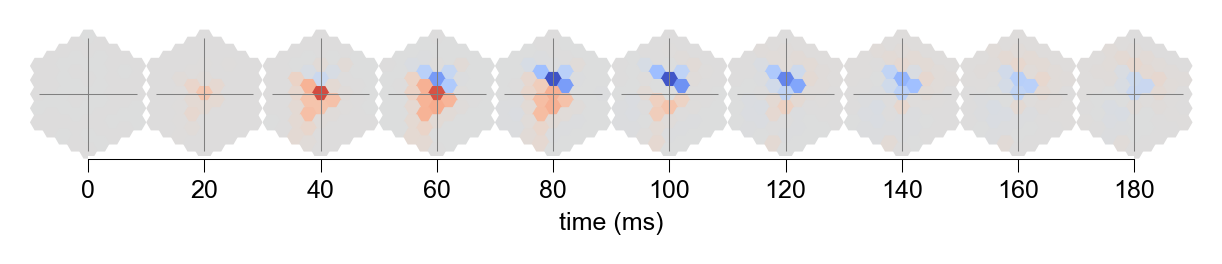

In [36]:
fig, axes = plot_strf(strfs.time, strfs.values.T)

### T5c

In [37]:
strfs = (
    flashes_and_resps['responses']
    .sel(network_id=cluster_indices["T5c"][0])
    .custom.where(t_impulse=0.02, cell_type="T5c", time=">=0,<0.25", intensity=1)
    .mean("network_id")
)

In [38]:
strfs = (strfs - strfs.isel(frame=0).mean().values).squeeze()

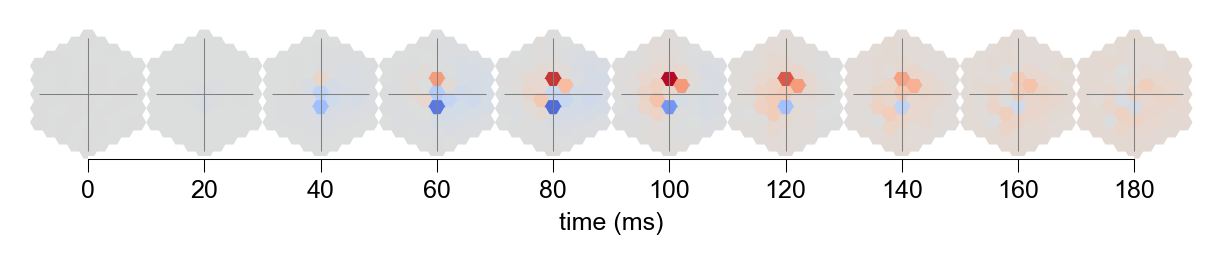

In [39]:
fig, axes = plot_strf(strfs.time, strfs.values.T)

## f

In [40]:
from flyvision.analysis.optimal_stimuli import plot_stim_response

In [41]:
network_view = ensemble[0]

In [42]:
optstims = network_view.optimal_stimulus_responses("T4c")

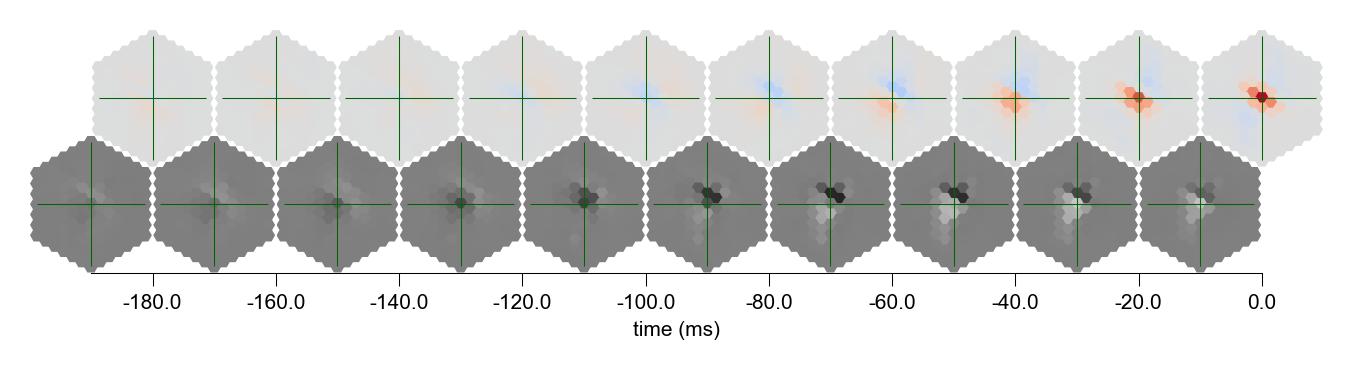

In [43]:
stim_resp_plot = plot_stim_response(
    optstims.regularized_stimulus,
    optstims.response,
    1 / 100,
    *network_view.get_uv("T4c"),
    figsize=[5, 1.6],
    ylabel=None,
    label_peak_response=False,
)

In [44]:
optstims = network_view.optimal_stimulus_responses("T5c")

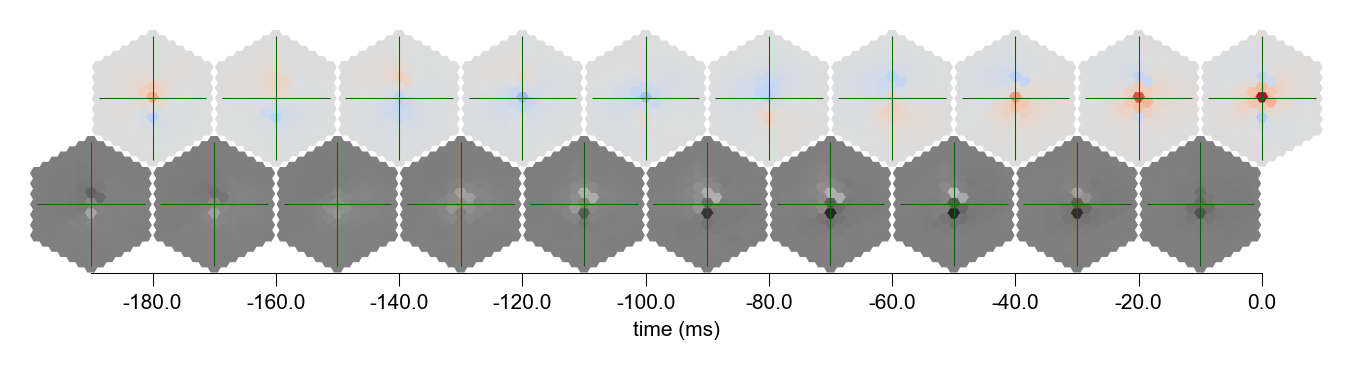

In [45]:
stim_resp_plot = plot_stim_response(
    optstims.regularized_stimulus,
    optstims.response,
    1 / 100,
    *network_view.get_uv("T5c"),
    figsize=[5, 1.6],
    ylabel=None,
    label_peak_response=False,
)